<a href="https://colab.research.google.com/github/EmilSeyfullayev/Home-prices-analytics/blob/main/Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import time
import datetime

In [ ]:
!pip install gsheetsdb

In [3]:
from gsheetsdb import connect

In [4]:
conn = connect()

In [5]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1J1Lw1vGLEIee31gMLiE8Oihy9LuWSKhvuDdf9qSEKMo/edit?usp=sharing'

In [6]:
df = pd.read_sql(f'SELECT * FROM "{sheet_url}"', conn)

In [7]:
df.shape

(18692, 26)

In [8]:
len(df.drop_duplicates(subset='ids')) # No duplicate ids

18692

In [9]:
checkpoint_raw = df.copy()

In [10]:
df = checkpoint_raw.copy()

# Analytics

## Preprocessing

In [11]:
df.columns.values

array(['ids', 'vipped_featured', 'prices', 'texts', 'categories',
       'floors', 'areas_m2', 'rooms', 'documents', 'credits', 'address',
       'district', 'latitudes', 'longitudes', 'ownerships', 'names',
       'emails', 'phone_numbers_appened', 'ad_number', 'watches',
       'ad_refreshed_date', 'agency_titles', 'photo_counts',
       'phot_pseudo_links', 'date_of_parsing', 'deal_ended'], dtype=object)

In [12]:
# Necessary columns
necessary_columns = [
                     "ids",
                     "vipped_featured", 
                     "prices",
                     "categories",
                     "floors",
                     "areas_m2",
                     "rooms",
                     "documents",
                     "credits",
                     "address",
                     "district",
                     "latitudes",
                     "longitudes",
                     "ownerships",
                     "watches",
                     "ad_refreshed_date",
                     "agency_titles",
                     "date_of_parsing",
                     "deal_ended"
]
df = df[necessary_columns]

In [13]:
df.head()

,ids,vipped_featured,prices,categories,floors,areas_m2,rooms,documents,credits,address,district,latitudes,longitudes,ownerships,watches,ad_refreshed_date,agency_titles,date_of_parsing,deal_ended
0,2348807,featuredvipped,54 000,Köhnə tikili,2 / 5,50 m²,2,var,var,"Ünvan: Bakı şəhəri, R.Şahsuvarov küç 31",Suraxanı r.; Hövsan q.,40.35582129,50.06357475,mülkiyyətçi,3363,01 Yanvar 2022,0,2022-01-03 11:36:55,0
1,1710054,vipped,289 000,Yeni tikili,5 / 17,180 m²,4,var,var,"Ünvan: Bakı şəhəri, Affiyədin Cəlilov küç.",Şah İsmayıl Xətai m.; Xətai r.,40.37891689,49.875682,mülkiyyətçi,7348,22 Dekabr 2021,0,2022-01-03 11:36:55,0
2,2524899,vipped,159 000,Yeni tikili,12 / 19,58 m²,2,var,var,"Ünvan: Bakı şəhəri, Azadlıq prospekti",ASAN Xidmət №1 ; TQDK ; Neftçi bazası ; Nəsimi r.,40.39841488,49.83920251,vasitəçi (agent),197,28 Dekabr 2021,0,2022-01-03 11:36:55,0
3,2529070,vipped,175 000,Yeni tikili,7 / 7,117 m²,3,var,var,"Ünvan: Bakı şəhəri, Xəqani Rüstəmov küçəsi 6",Əhmədli m.; Xətai r.,40.3816452,49.9584505,mülkiyyətçi,376,25 Dekabr 2021,0,2022-01-03 11:36:55,0
4,2541267,0,104 000,Yeni tikili,11 / 12,65 m²,2,var,xeyr,"Ünvan: Bakı şəhəri, S.S.Axundov küç.",Azadlıq Prospekti m.; Binəqədi r.; 8-ci mikror...,40.42705637,49.84432445,vasitəçi (agent),28,Bugün 15:20,New House 20 Yanvar daşınmaz əmlak agentliyi,2022-01-03 11:36:55,0


In [14]:
df.shape

(18692, 19)

### Vipped Featured ordinary ads

In [15]:
df['vipped_featured'].value_counts()

0                 18302
vipped              278
featuredvipped       86
featured             26
Name: vipped_featured, dtype: int64

In [16]:
ad_type = pd.get_dummies(df['vipped_featured'], prefix='ad_type', drop_first=True)
ad_type # ad_type_0 is reference category

,ad_type_featured,ad_type_featuredvipped,ad_type_vipped
0,0,1,0
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,0
...,...,...,...
18687,0,0,0
18688,0,0,0
18689,0,0,0
18690,0,0,0


In [17]:
df = pd.concat([df, ad_type], axis=1)
df.columns.values

array(['ids', 'vipped_featured', 'prices', 'categories', 'floors',
       'areas_m2', 'rooms', 'documents', 'credits', 'address', 'district',
       'latitudes', 'longitudes', 'ownerships', 'watches',
       'ad_refreshed_date', 'agency_titles', 'date_of_parsing',
       'deal_ended', 'ad_type_featured', 'ad_type_featuredvipped',
       'ad_type_vipped'], dtype=object)

### Price

In [18]:
df['prices'] = pd.to_numeric(
    df['prices'].apply(lambda x: str(x).replace(" ", ""))
)

### Categories

In [19]:
df['categories'].value_counts()

Yeni tikili     12600
Köhnə tikili     6086
0                   6
Name: categories, dtype: int64

In [20]:
categories = pd.get_dummies(df['categories'], drop_first=True) # 0 is reference category
categories

,Köhnə tikili,Yeni tikili
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
18687,1,0
18688,1,0
18689,0,1
18690,0,1


In [21]:
df = pd.concat([df, categories], axis=1)
df.columns.values

array(['ids', 'vipped_featured', 'prices', 'categories', 'floors',
       'areas_m2', 'rooms', 'documents', 'credits', 'address', 'district',
       'latitudes', 'longitudes', 'ownerships', 'watches',
       'ad_refreshed_date', 'agency_titles', 'date_of_parsing',
       'deal_ended', 'ad_type_featured', 'ad_type_featuredvipped',
       'ad_type_vipped', 'Köhnə tikili', 'Yeni tikili'], dtype=object)

### Floors

In [22]:
df['floors'].value_counts()

5 / 5      681
4 / 5      670
3 / 5      550
2 / 5      516
1 / 5      359
          ... 
3 / 33       1
16 / 30      1
18 / 32      1
1 / 19       1
25 / 27      1
Name: floors, Length: 346, dtype: int64

In [23]:
apartment_floor = df['floors'].apply(lambda x: str(x).split(" / ")[0])

buildings_floor = []

for i in df['floors']:
  try:
    buildings_floor.append(str(i).split(" / ")[1])
  except:
    buildings_floor.append(np.nan)

In [24]:
df['apartment_floor'] = apartment_floor
df['buildings_floor'] = buildings_floor

In [25]:
df['apartment_floor'] = pd.to_numeric(df['apartment_floor'])
df['buildings_floor'] = pd.to_numeric(df['buildings_floor'])

In [26]:
df['percent_of_building_height'] = round(df['apartment_floor']/df['buildings_floor']*100)

### Area m2

In [27]:
df['areas_m2'] = df['areas_m2'].apply(lambda x: float(x.rstrip(" m²")))

### Rooms

In [28]:
df['rooms'] = pd.to_numeric(df['rooms'])

### Documents and Credits availability

In [29]:
df['documents'].value_counts()

var    18686
0          6
Name: documents, dtype: int64

In [30]:
df[df['documents'] == "0"] # so I think to drop all rows with this condition

,ids,vipped_featured,prices,categories,floors,areas_m2,rooms,documents,credits,address,district,latitudes,longitudes,ownerships,watches,ad_refreshed_date,agency_titles,date_of_parsing,deal_ended,ad_type_featured,ad_type_featuredvipped,ad_type_vipped,Köhnə tikili,Yeni tikili,apartment_floor,buildings_floor,percent_of_building_height
574,2540391,0,0,0,0,0.0,0,0,xeyr,0,None,0,0,0,0,0,0,2022-01-03 13:48:28,0,0,0,0,0,0,0,NaN,NaN
1809,2537858,0,0,0,0,0.0,0,0,xeyr,0,None,0,0,0,0,0,0,2022-01-03 16:45:50,0,0,0,0,0,0,0,NaN,NaN
2176,2517926,0,0,0,0,0.0,0,0,xeyr,0,None,0,0,0,0,0,0,2022-01-04 02:11:18,0,0,0,0,0,0,0,NaN,NaN
4480,2529047,0,0,0,0,0.0,0,0,xeyr,0,None,0,0,0,0,0,0,2022-01-04 08:33:26,0,0,0,0,0,0,0,NaN,NaN
11144,2518566,0,0,0,0,0.0,0,0,xeyr,0,None,0,0,0,0,0,0,2022-01-04 10:59:18,0,0,0,0,0,0,0,NaN,NaN
12459,2502400,0,0,0,0,0.0,0,0,xeyr,0,None,0,0,0,0,0,0,2022-01-04 14:07:11,0,0,0,0,0,0,0,NaN,NaN


In [31]:
df = df[~(df['documents'] == "0")].reset_index(drop=True)

In [32]:
df['documents'].value_counts() # drop whole column

var    18686
Name: documents, dtype: int64

In [33]:
df = df.drop('documents', axis=1)

In [34]:
df['credits'].value_counts()

xeyr    15424
var      3262
Name: credits, dtype: int64

In [35]:
credits = pd.get_dummies(df['credits'], prefix='Credit')
credits = credits['Credit_var'] # Credit_xeyr will be reference category

In [36]:
df = pd.concat([df, credits], axis=1)

### Address and District

In [37]:
df['address'].isna().sum()

0

In [38]:
len(df['address'].unique())

7257

In [39]:
df['address'].value_counts().head(10)

Ünvan: Bakı şəhəri, Gəncə prospekti       264
Ünvan: Bakı şəhəri, Mir Cəlal küç.        189
Ünvan: Bakı şəhəri, Azadlıq pr.           171
Ünvan: Bakı şəhəri, Məhəmməd Hadi küç.    169
Ünvan: Bakı şəhəri, Əsəd Əhmədov küç.     166
Ünvan: Bakı şəhəri, Gəncə pr.             160
Ünvan: Bakı şəhəri, Təbriz küç.           131
Ünvan: Bakı şəhəri, Azadlıq prospekti     126
Ünvan: Bakı şəhəri, Şərifzadə küç.        124
Ünvan: Bakı şəhəri, Əliyar Əliyev küç.    108
Name: address, dtype: int64

In [40]:
df['address'] = df['address'].apply(lambda x: x.lstrip("Ünvan: Bakı şəhəri, "))

In [41]:
df['address'].value_counts().head(10)

Gəncə prospekti       264
Mir Cəlal küç.        189
Azadlıq pr.           172
Məhəmməd Hadi küç.    169
Əsəd Əhmədov küç.     166
Gəncə pr.             160
Azadlıq prospekti     131
Təbriz küç.           131
Şərifzadə küç.        124
Əliyar Əliyev küç.    109
Name: address, dtype: int64

In [42]:
df['address'].value_counts().sum() #they are too much to create dummy variables

18686

In [128]:
df = df[df['latitudes']>38]

In [129]:
df['district'].value_counts().head(10)

Şah İsmayıl Xətai m.; Xətai r.                                  907
Yasamal r.; Yeni Yasamal q.                                     903
Xətai r.; Əhmədli q.                                            561
Nərimanov r.                                                    507
İnşaatçılar m.; Yasamal r.                                      409
Yasamal r.                                                      371
Nəriman Nərimanov m.; Nərimanov r.                              300
Azadlıq Prospekti m.; Binəqədi r.; 8-ci mikrorayon q.           293
Nəriman Nərimanov m.; Nəriman Nərimanov parkı ; Nərimanov r.    286
Sabunçu r.; Bakıxanov q.                                        285
Name: district, dtype: int64

In [130]:
def number_of_max_district_per_one_home():
  n = 0
  for i in df['district'].apply(lambda x: x.split("; ")):
    if len(i) > n:
      n = len(i)
  
  return n

number_of_max_district_per_one_home()
    


12

In [131]:
df['district'].apply(lambda x: x.split("; "))

0                                 [Suraxanı r., Hövsan q.]
1                         [Şah İsmayıl Xətai m., Xətai r.]
2        [ASAN Xidmət №1 , TQDK , Neftçi bazası , Nəsim...
3                                   [Əhmədli m., Xətai r.]
4        [Azadlıq Prospekti m., Binəqədi r., 8-ci mikro...
                               ...                        
18681    [Xalqlar Dostluğu m., Nizami r., 8-ci kilometr...
18682    [Xalqlar Dostluğu m., Nizami r., 8-ci kilometr...
18683    [İncəsənət və Mədəniyyət Un. , Hüseyn Cavid pa...
18684    [Azərbaycan turizm institutu , Respublika stad...
18685                                          [Nizami r.]
Name: district, Length: 18685, dtype: object

In [132]:
districts_in_lists = list(df['district'].apply(lambda x: x.split("; ")))

In [133]:
districts_in_lists[:10]

[['Suraxanı r.', 'Hövsan q.'],
 ['Şah İsmayıl Xətai m.', 'Xətai r.'],
 ['ASAN Xidmət №1 ', 'TQDK ', 'Neftçi bazası ', 'Nəsimi r.'],
 ['Əhmədli m.', 'Xətai r.'],
 ['Azadlıq Prospekti m.', 'Binəqədi r.', '8-ci mikrorayon q.'],
 ['Nəsimi bazarı ',
  'Koala parkı ',
  'Dostluq kinoteatrı ',
  'Park Zorge ',
  'Nərimanov r.'],
 ['Nəriman Nərimanov m.', 'Nəriman Nərimanov parkı ', 'Nərimanov r.'],
 ['Suraxanı r.', 'Qaraçuxur q.'],
 ['8 Noyabr m.', 'Nəsimi r.'],
 ['Axundov bağı ',
  'İqsadiyyat Universiteti ',
  'Dövlət İdarəçilik Akademiyası ',
  'İçəri Şəhər m.',
  'Prezident parkı ',
  'Qubernator parkı ',
  'Sovetski ',
  'Nərimanov heykəli ',
  'M.Ə.Sabir parkı ',
  'Səbail r.']]

In [134]:
districts = []

for i in districts_in_lists:
  for z in i:
    districts.append(z.strip())

In [135]:
districts[:10]

['Suraxanı r.',
 'Hövsan q.',
 'Şah İsmayıl Xətai m.',
 'Xətai r.',
 'ASAN Xidmət №1',
 'TQDK',
 'Neftçi bazası',
 'Nəsimi r.',
 'Əhmədli m.',
 'Xətai r.']

In [136]:
len(districts)

51694

In [137]:
len(set(districts))

182

In [138]:
pd.Series(districts).value_counts().head(100).reset_index()['index']

0             Yasamal r.
1               Xətai r.
2              Nəsimi r.
3           Nərimanov r.
4            Binəqədi r.
             ...        
95              Space TV
96    3-cü mikrorayon q.
97             Port Baku
98          Xalça Muzeyi
99            Masazır q.
Name: index, Length: 100, dtype: object

In [139]:
districts_for_dummies = list(pd.Series(districts).value_counts().head(100).reset_index()['index'])

### First variant districts

In [140]:
districts_for_dummies = ['Yasamal r.', 'Xətai r.', 'Nəsimi r.', 'Nərimanov r.',
       'Binəqədi r.', 'Şah İsmayıl Xətai m.', 'Nizami r.', 'Əhmədli q.',
       'Yeni Yasamal q.', 'İnşaatçılar m.', 'Yasamal q.',
       'Elmlər Akademiyası m.', 'Nəriman Nərimanov m.', 'Səbail r.',
       'Memar Əcəmi m.', 'Həzi Aslanov m.', '28 May m.', 'Nizami m.',
       'Yasamal bazarı', '8-ci kilometr q.', 'ASAN Xidmət №1',
       '8-ci mikrorayon q.', 'Nəriman Nərimanov parkı',
       'Tibb Universiteti', '9-cu mikrorayon q.', 'Gənclik m.',
       'Neftçi bazası', 'Azadlıq Prospekti m.', '20 Yanvar m.',
       'Həzi Aslanov q.', 'Qara Qarayev m.', 'Əhmədli m.', 'Sabunçu r.',
       '8 Noyabr m.', 'Azərbaycan Dillər Universiteti', 'Neftçilər m.',
       'Bakı Slavyan Universiteti', 'Nəsimi bazarı', 'Sahil m.',
       '4-cü mikrorayon q.', 'Səməd Vurğun parkı', 'Hüseyn Cavid parkı',
       'ASAN Xidmət №3', 'Sirk', 'Dövlət Statistika Komitəsi',
       'Təhsil Nazirliyi', 'Bakıxanov q.', 'Respublika stadionu',
       'İçəri Şəhər m.', 'İncəsənət və Mədəniyyət Un.', 'Koala parkı',
       'Neft Akademiyası', 'Azərbaycan turizm institutu',
       'Zərifə Əliyeva adına park', 'Bakı Musiqi Akademiyası',
       'Zabitlər parkı', 'Beşmərtəbə', 'Bakı Asiya Universiteti',
       'Suraxanı r.', 'Milli Konservatoriya', '7-ci mikrorayon q.',
       'Dostluq kinoteatrı', 'Xalqlar Dostluğu m.', 'M.Hüseynzadə parkı',
       'Bakı Dövlət Universiteti', 'Nizami kinoteatrı',
       'Texniki Universiteti', 'Şərq bazarı', 'Malokan bağı',
       'ASAN Xidmət №2', 'TQDK', 'Cavanşir körpüsü', 'Sahil bağı',
       'Pedaqoji Universiteti', 'M.Ə.Sabir parkı', 'Rusiya səfirliyi',
       'Park Zorge', 'Rəssamlıq Akademiyası', 'Zoopark',
       'Nərimanov heykəli', 'Axundov bağı', 'Mərkəzi Univermaq',
       'Sevil Qazıyeva parkı', 'İqsadiyyat Universiteti', 'Abşeron r.',
       'Sovetski', 'İzmir parkı', 'Qış parkı',
       'Dövlət İdarəçilik Akademiyası', 'Fontanlar bağı',
       'Qubernator parkı', 'Prezident parkı', 'Nəsimi m.', 'Ağ şəhər',
       'Badamdar q.', 'Space TV', 'Xalça Muzeyi', 'Port Baku',
       '3-cü mikrorayon q.', 'Masazır q.']

In [141]:
districts_set = list(set(districts))

In [142]:
def district_dummies_vars():

  district = []

  for list_of_districts in districts_in_lists:

    if list_of_districts[0] in districts_for_dummies:
      
      district.append(list_of_districts[0])

    else:

      district.append('0')
  
  return district

In [143]:
district_variable = district_dummies_vars()

In [144]:
pd.Series(district_variable).value_counts()

0                        6553
Yasamal r.               1409
Xətai r.                 1088
Şah İsmayıl Xətai m.      968
Binəqədi r.               805
İnşaatçılar m.            744
Memar Əcəmi m.            730
Həzi Aslanov m.           631
Nəriman Nərimanov m.      602
Nərimanov r.              508
Elmlər Akademiyası m.     403
Azadlıq Prospekti m.      396
Qara Qarayev m.           379
Neftçilər m.              347
20 Yanvar m.              344
Sabunçu r.                340
Səbail r.                 320
Əhmədli m.                301
Nizami r.                 225
Suraxanı r.               222
Xalqlar Dostluğu m.       221
Gənclik m.                220
Nizami m.                 169
Abşeron r.                168
8 Noyabr m.               158
Nəsimi r.                 145
Nəsimi m.                 113
28 May m.                  91
Sahil m.                   65
İçəri Şəhər m.             20
dtype: int64

In [145]:
len(district_variable) # we can add this variable

18685

In [146]:
df.shape

(18685, 27)

In [147]:
second_variant_districts = [x[0] for x in districts_in_lists]

In [148]:
pd.Series(second_variant_districts).value_counts()

Yasamal r.              1409
Xətai r.                1088
Şah İsmayıl Xətai m.     968
Binəqədi r.              805
İnşaatçılar m.           744
                        ... 
Pirallahı r.               5
Keşlə bazarı               4
Bakı                       2
Ulduz m.                   1
Şəfa stadionu              1
Length: 115, dtype: int64

In [149]:
def second_variant_district_var():

  first_district = []

  for i in districts_in_lists:  
    first_district.append(i[0])

  return first_district


In [150]:
# first variant was about selecting the most frequent districts
# second variant was about selecting the first district indicated in by the seller

In [151]:
first_district_indicated_by_seller = second_variant_district_var()

In [152]:
len(first_district_indicated_by_seller)

18685

In [153]:
df.shape

(18685, 27)

In [154]:
df['longitudes'] = pd.to_numeric(df['longitudes'])
df['latitudes'] = pd.to_numeric(df['latitudes'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


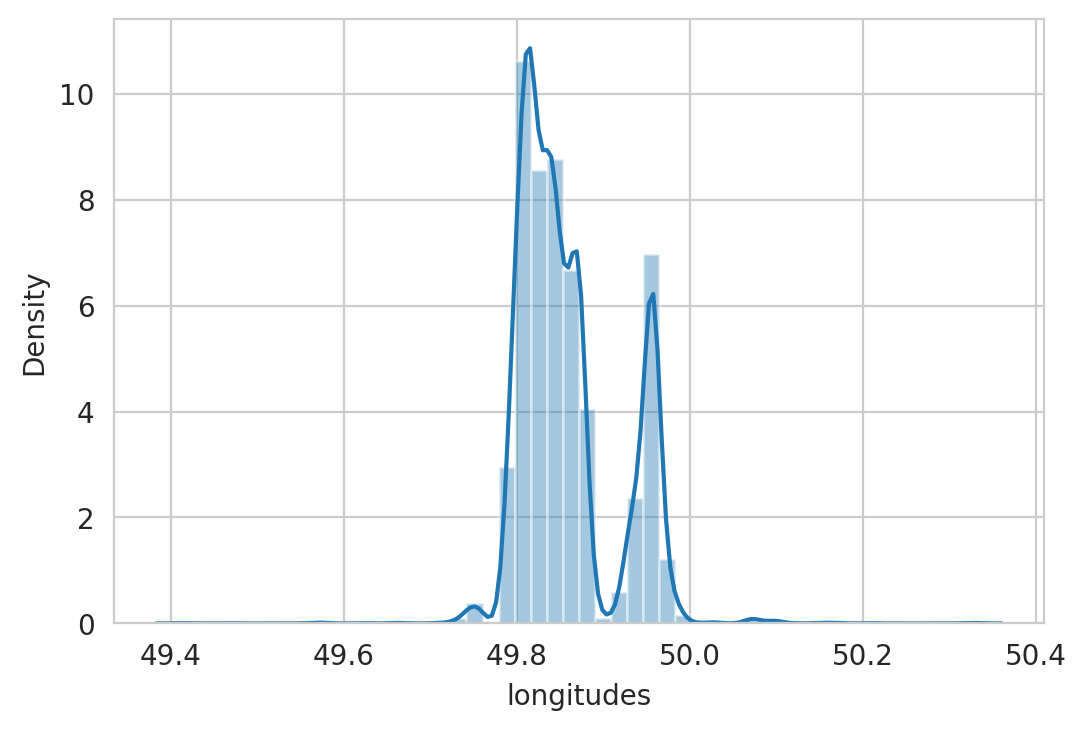

In [155]:
plt.figure(dpi=200)
sns.distplot(df[df['longitudes']>48]['longitudes'])

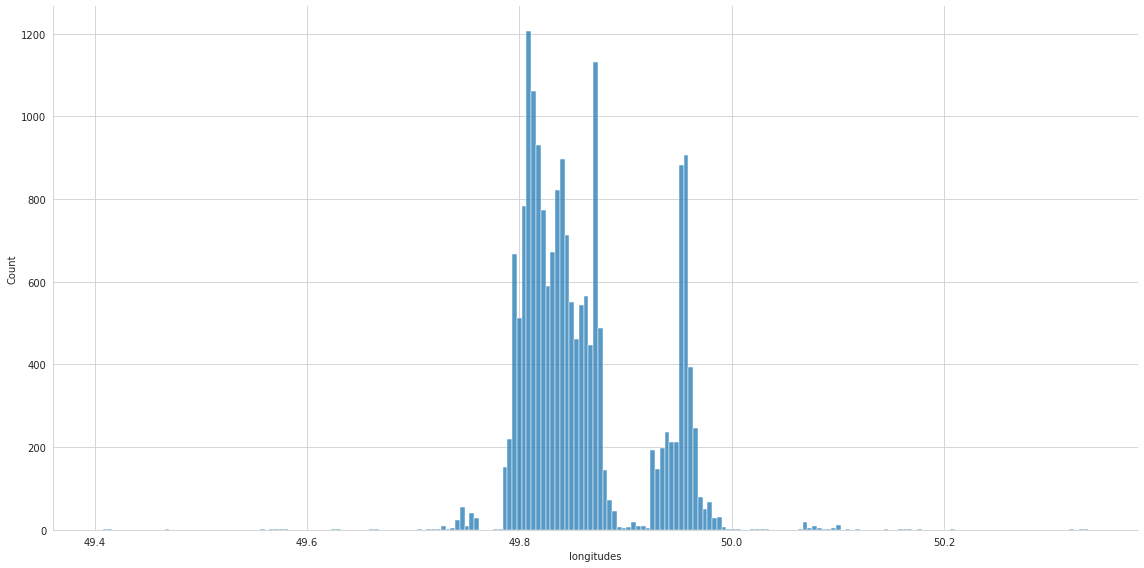

In [156]:
sns.displot(df[df['longitudes']>48]['longitudes'], height=8, aspect=2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


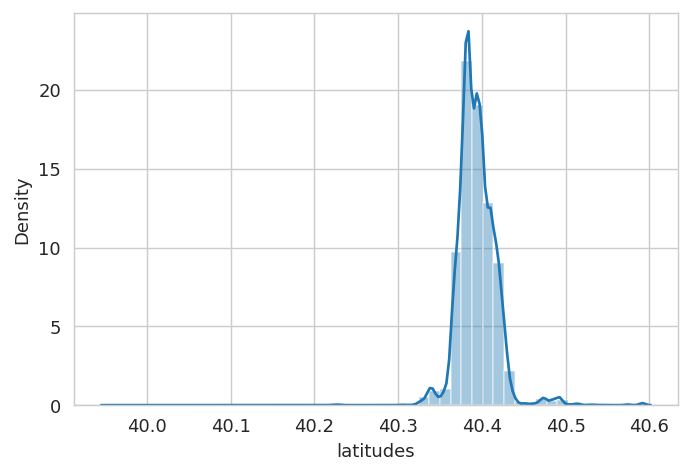

In [157]:
plt.figure(dpi=130)
sns.distplot(df[df['latitudes']>39]['latitudes'])

In [158]:
df['latitudes'].max()

40.59192636277074

In [159]:
df['latitudes'].min()

39.95504531271095

In [160]:
df['latitudes'].mean()

40.39404097300845

In [161]:
df[df['latitudes'] < 38]

,ids,vipped_featured,prices,categories,floors,areas_m2,rooms,credits,address,district,latitudes,longitudes,ownerships,watches,ad_refreshed_date,agency_titles,date_of_parsing,deal_ended,ad_type_featured,ad_type_featuredvipped,ad_type_vipped,Köhnə tikili,Yeni tikili,apartment_floor,buildings_floor,percent_of_building_height,Credit_var


In [162]:
len(districts_set)

182

In [163]:
#example
df[df['district'].str.contains("Suraxanı r.;")]

,ids,vipped_featured,prices,categories,floors,areas_m2,rooms,credits,address,district,latitudes,longitudes,ownerships,watches,ad_refreshed_date,agency_titles,date_of_parsing,deal_ended,ad_type_featured,ad_type_featuredvipped,ad_type_vipped,Köhnə tikili,Yeni tikili,apartment_floor,buildings_floor,percent_of_building_height,Credit_var
0,2348807,featuredvipped,54000,Köhnə tikili,2 / 5,50.0,2,var,R.Şahsuvarov küç 31,Suraxanı r.; Hövsan q.,40.355821,50.063575,mülkiyyətçi,3363,01 Yanvar 2022,0,2022-01-03 11:36:55,0,0,1,0,1,0,2,5.0,40.0,1
7,2541260,0,83800,Köhnə tikili,5 / 5,81.6,3,var,"H. Əhmədov küç, b 8, m 89.",Suraxanı r.; Qaraçuxur q.,40.413457,49.960525,vasitəçi (agent),22,Bugün 15:16,0,2022-01-03 11:36:55,0,0,0,0,1,0,5,5.0,100.0,1
101,2541155,0,40000,Köhnə tikili,2 / 2,88.0,6,xeyr,Axundov küçəsi ev16,Suraxanı r.; Bülbülə q.,40.434177,49.968055,mülkiyyətçi,22,Bugün 14:46,0,2022-01-03 13:48:28,0,0,0,0,1,0,2,2.0,100.0,0
367,2540746,0,83000,Köhnə tikili,4 / 9,90.0,3,xeyr,Samir Cəfərov küçəsi,Xalqlar Dostluğu m.; Suraxanı r.; Yeni Günəşli q.,40.397586,49.952898,vasitəçi (agent),129,Bugün 12:24,Azər RA Əmlak daşınmaz əmlak agentliyi,2022-01-03 13:48:28,0,0,0,0,1,0,4,9.0,44.0,0
429,2397222,0,80000,Köhnə tikili,9 / 9,70.0,3,var,Yeni Günəşli Q massiv,Suraxanı r.; Yeni Günəşli q.,40.377675,49.960670,mülkiyyətçi,1275,Bugün 11:45,0,2022-01-03 13:48:28,0,0,0,0,1,0,9,9.0,100.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18461,2550315,0,112000,Köhnə tikili,3 / 9,100.0,4,xeyr,Yeni Günəşli D massivi,Suraxanı r.; Yeni Günəşli q.,40.385738,50.030156,vasitəçi (agent),138,Dünən 19:25,0,2022-01-08 11:17:50,0,0,0,0,1,0,3,9.0,33.0,0
18468,2550299,0,52000,Köhnə tikili,8 / 9,35.0,1,xeyr,"Yeni Günəşli, V massivi bina 22",Suraxanı r.; Massiv V q.,40.387384,49.982021,mülkiyyətçi,127,Dünən 19:20,0,2022-01-08 11:17:50,0,0,0,0,1,0,8,9.0,89.0,0
18474,2523339,0,67000,Köhnə tikili,6 / 9,57.4,2,xeyr,Massiv - D/Bina-17/Mənzil-65,Suraxanı r.; Yeni Günəşli q.,40.372595,49.978764,mülkiyyətçi,714,Dünən 19:09,0,2022-01-08 11:17:50,0,0,0,0,1,0,6,9.0,67.0,0
18565,2550101,0,110000,Köhnə tikili,8 / 9,100.0,4,xeyr,"Yeni Günəşli qəs, AB massivi",Suraxanı r.; Massiv A q.,40.382380,49.974835,vasitəçi (agent),109,Dünən 17:50,0,2022-01-08 11:17:50,0,0,0,0,1,0,8,9.0,89.0,0


In [164]:
latitude_mean = []
longitude_mean = []


for i in districts_set:

  latitude_mean.append(df[df['district'].str.contains(i)]['latitudes'].mean())
  longitude_mean.append(df[df['district'].str.contains(i)]['longitudes'].mean())



In [165]:
districts_temp = pd.DataFrame()
districts_temp['districts'] = districts_set
districts_temp['latitude_mean'] = latitude_mean
districts_temp['longitude_mean'] = longitude_mean


In [166]:
districts_temp

,districts,latitude_mean,longitude_mean
0,Çiçək q.,40.460965,49.662923
1,Azərbaycan kinoteatrı,40.370208,49.836696
2,Sevil Qazıyeva parkı,40.386949,49.832329
3,Biləcəri q.,40.432181,49.803850
4,Yasamal r.,40.385984,49.807679
...,...,...,...
177,Beşmərtəbə,40.377416,49.831915
178,Şimal DRES q.,40.487628,50.209064
179,Kürdəxanı q.,40.547881,49.904194
180,Şah İsmayıl Xətai m.,40.383049,49.872086


In [167]:
districts_temp.to_excel("lat_long.xlsx")

In [168]:
final_latitude = []
final_longitude = []

for i in districts_in_lists:

  final_latitude.append(
      districts_temp[districts_temp['districts'].str.contains("|".join(i))]['latitude_mean'].mean()
  )

  final_longitude.append(
      districts_temp[districts_temp['districts'].str.contains("|".join(i))]['longitude_mean'].mean()
  )
  

In [169]:
len(final_latitude)

18685

In [170]:
len(final_longitude)

18685

In [171]:
df['final_latitude'] = final_latitude
df['final_longitude'] = final_longitude

In [172]:
df

,ids,vipped_featured,prices,categories,floors,areas_m2,rooms,credits,address,district,latitudes,longitudes,ownerships,watches,ad_refreshed_date,agency_titles,date_of_parsing,deal_ended,ad_type_featured,ad_type_featuredvipped,ad_type_vipped,Köhnə tikili,Yeni tikili,apartment_floor,buildings_floor,percent_of_building_height,Credit_var,final_latitude,final_longitude
0,2348807,featuredvipped,54000,Köhnə tikili,2 / 5,50.0,2,var,R.Şahsuvarov küç 31,Suraxanı r.; Hövsan q.,40.355821,50.063575,mülkiyyətçi,3363,01 Yanvar 2022,0,2022-01-03 11:36:55,0,0,1,0,1,0,2,5.0,40.0,1,40.380489,50.032700
1,1710054,vipped,289000,Yeni tikili,5 / 17,180.0,4,var,Affiyədin Cəlilov küç.,Şah İsmayıl Xətai m.; Xətai r.,40.378917,49.875682,mülkiyyətçi,7348,22 Dekabr 2021,0,2022-01-03 11:36:55,0,0,0,1,0,1,5,17.0,29.0,1,40.380310,49.897551
2,2524899,vipped,159000,Yeni tikili,12 / 19,58.0,2,var,Azadlıq prospekti,ASAN Xidmət №1 ; TQDK ; Neftçi bazası ; Nəsimi r.,40.398415,49.839203,vasitəçi (agent),197,28 Dekabr 2021,0,2022-01-03 11:36:55,0,0,0,1,0,1,12,19.0,63.0,1,40.395985,49.830862
3,2529070,vipped,175000,Yeni tikili,7 / 7,117.0,3,var,Xəqani Rüstəmov küçəsi 6,Əhmədli m.; Xətai r.,40.381645,49.958450,mülkiyyətçi,376,25 Dekabr 2021,0,2022-01-03 11:36:55,0,0,0,1,0,1,7,7.0,100.0,1,40.380453,49.939698
4,2541267,0,104000,Yeni tikili,11 / 12,65.0,2,xeyr,S.S.Axundov küç.,Azadlıq Prospekti m.; Binəqədi r.; 8-ci mikror...,40.427056,49.844324,vasitəçi (agent),28,Bugün 15:20,New House 20 Yanvar daşınmaz əmlak agentliyi,2022-01-03 11:36:55,0,0,0,0,0,1,11,12.0,92.0,0,40.423288,49.838120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18681,2549837,0,76000,Köhnə tikili,1 / 5,60.0,2,var,Elşən Süleymanov küç.,Xalqlar Dostluğu m.; Nizami r.; 8-ci kilometr q.,40.396238,49.958658,mülkiyyətçi,130,Dünən 16:20,0,2022-01-08 11:17:50,0,0,0,0,1,0,1,5.0,20.0,1,40.405938,49.945491
18682,2549836,0,63000,Köhnə tikili,5 / 9,40.0,2,xeyr,Cəmşid Naxçıvanski küç.,Xalqlar Dostluğu m.; Nizami r.; 8-ci kilometr q.,40.402667,49.958212,vasitəçi (agent),321,Dünən 16:20,0,2022-01-08 11:17:50,0,0,0,0,1,0,5,9.0,56.0,0,40.405938,49.945491
18683,2549834,0,530000,Yeni tikili,4 / 17,162.0,3,xeyr,Qutqaşınlı küç.56,İncəsənət və Mədəniyyət Un. ; Hüseyn Cavid par...,40.375866,49.820146,vasitəçi (agent),64,Dünən 16:20,VİP House daşınmaz əmlak agentliyi,2022-01-08 11:17:50,0,0,0,0,0,1,4,17.0,24.0,0,40.381254,49.810698
18684,1476679,0,230000,Yeni tikili,12 / 16,146.0,3,xeyr,A.Cümə küç. 83,Azərbaycan turizm institutu ; Respublika stadi...,40.399796,49.859174,vasitəçi (agent),2927,Dünən 16:18,Yadigar Əmlak daşınmaz əmlak agentliyi,2022-01-08 11:17:50,0,0,0,0,0,1,12,16.0,75.0,0,40.401032,49.857534


In [174]:
df.shape

(18685, 29)

In [178]:
df[['district','latitudes', 'longitudes', 'final_latitude', 'final_longitude']]

,district,latitudes,longitudes,final_latitude,final_longitude
0,Suraxanı r.; Hövsan q.,40.355821,50.063575,40.380489,50.032700
1,Şah İsmayıl Xətai m.; Xətai r.,40.378917,49.875682,40.380310,49.897551
2,ASAN Xidmət №1 ; TQDK ; Neftçi bazası ; Nəsimi r.,40.398415,49.839203,40.395985,49.830862
3,Əhmədli m.; Xətai r.,40.381645,49.958450,40.380453,49.939698
4,Azadlıq Prospekti m.; Binəqədi r.; 8-ci mikror...,40.427056,49.844324,40.423288,49.838120
...,...,...,...,...,...
18681,Xalqlar Dostluğu m.; Nizami r.; 8-ci kilometr q.,40.396238,49.958658,40.405938,49.945491
18682,Xalqlar Dostluğu m.; Nizami r.; 8-ci kilometr q.,40.402667,49.958212,40.405938,49.945491
18683,İncəsənət və Mədəniyyət Un. ; Hüseyn Cavid par...,40.375866,49.820146,40.381254,49.810698
18684,Azərbaycan turizm institutu ; Respublika stadi...,40.399796,49.859174,40.401032,49.857534


In [180]:
df.columns.values

array(['ids', 'vipped_featured', 'prices', 'categories', 'floors',
       'areas_m2', 'rooms', 'credits', 'address', 'district', 'latitudes',
       'longitudes', 'ownerships', 'watches', 'ad_refreshed_date',
       'agency_titles', 'date_of_parsing', 'deal_ended',
       'ad_type_featured', 'ad_type_featuredvipped', 'ad_type_vipped',
       'Köhnə tikili', 'Yeni tikili', 'apartment_floor',
       'buildings_floor', 'percent_of_building_height', 'Credit_var',
       'final_latitude', 'final_longitude'], dtype=object)

### Ownership

In [183]:
df['ownerships'].value_counts()

vasitəçi (agent)    16432
mülkiyyətçi          2243
0                      10
Name: ownerships, dtype: int64

In [185]:
df = df[df['ownerships'] != '0']

In [187]:
df['ownerships'].value_counts()

vasitəçi (agent)    16432
mülkiyyətçi          2243
Name: ownerships, dtype: int64

In [189]:
self_owner  = pd.get_dummies(df['ownerships'])["mülkiyyətçi"]

In [191]:
df = pd.concat([df, self_owner], axis=1)

### Agency titles

In [197]:
temp = df['agency_titles'].value_counts().reset_index()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


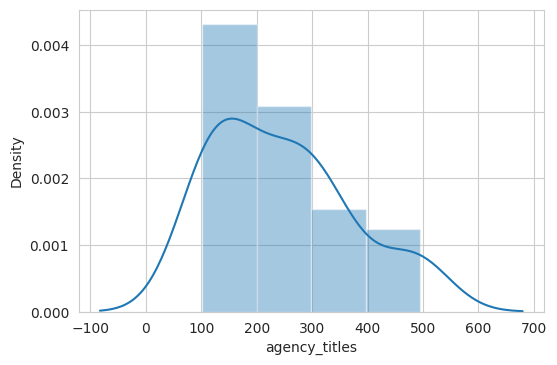

In [205]:
plt.figure(dpi=100)
sns.distplot(temp[temp['agency_titles']>100].iloc[1:]['agency_titles'])

In [208]:
top_agencies = ['New House 28 May daşınmaz əmlak agentliyi',
       'New House 20 Yanvar daşınmaz əmlak agentliyi',
       'Real Əmlak Yeni Yasamal daşınmaz əmlak agentliyi',
       'Real Əmlak Bakı  daşınmaz əmlak agentliyi',
       'Garant Əmlak daşınmaz əmlak agentliyi',
       'Real Əmlak Həzi Aslanov daşınmaz əmlak agentliyi',
       'New House Gənclik daşınmaz əmlak agentliyi',
       'New House Elmlər daşınmaz əmlak agentliyi',
       'Real Əmlak Gənclik daşınmaz əmlak agentliyi',
       'New House Mətbuat daşınmaz əmlak agentliyi',
       'YeniPark daşınmaz əmlak agentliyi',
       'Rich Estate Baku daşınmaz əmlak agentliyi',
       'Elmlər Əmlak daşınmaz əmlak agentliyi',
       'Dostluq Əmlak daşınmaz əmlak agentliyi',
       'Qarayev Əmlak daşınmaz əmlak agentliyi',
       'Avalon daşınmaz əmlak agentliyi',
       'New Life daşınmaz əmlak agentliyi',
       'Nərimanov Əmlak daşınmaz əmlak agentliyi',
       'Real Əmlak Parlament daşınmaz əmlak agentliyi',
       'Əcəmi Əmlak daşınmaz əmlak agentliyi',
       'Azadlıq Əmlak daşınmaz əmlak agentliyi',
       'Qarabağ Əmlak daşınmaz əmlak agentliyi',
       'Az House daşınmaz əmlak agentliyi',
       'Caspian daşınmaz əmlak agentliyi',
       'VİP House daşınmaz əmlak agentliyi',
       'City M House daşınmaz əmlak agentliyi',
       'Baku Realtor daşınmaz əmlak agentliyi',
       'Real Əmlak Nizami  daşınmaz əmlak agentliyi',
       'Hemax daşınmaz əmlak agentliyi',
       'Baku House daşınmaz əmlak agentliyi',
       'Zirvə RA Əmlak daşınmaz əmlak agentliyi',
       'Rahat Ev daşınmaz əmlak agentliyi',
       'News Service daşınmaz əmlak agentliyi']

In [195]:
len(df['agency_titles'].unique()) # we could create dummies

131

In [209]:
df['agency_top_100'] = df['agency_titles'].apply(lambda x: x if x in top_agencies else 0)

In [213]:
df_agencies = pd.get_dummies(df['agency_top_100'], prefix='Has more 100 houses', prefix_sep=":")

In [214]:
df_agencies.head()

,Has more 100 houses:0,Has more 100 houses:Avalon daşınmaz əmlak agentliyi,Has more 100 houses:Az House daşınmaz əmlak agentliyi,Has more 100 houses:Azadlıq Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Baku House daşınmaz əmlak agentliyi,Has more 100 houses:Baku Realtor daşınmaz əmlak agentliyi,Has more 100 houses:Caspian daşınmaz əmlak agentliyi,Has more 100 houses:City M House daşınmaz əmlak agentliyi,Has more 100 houses:Dostluq Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Elmlər Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Garant Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Hemax daşınmaz əmlak agentliyi,Has more 100 houses:New House 20 Yanvar daşınmaz əmlak agentliyi,Has more 100 houses:New House 28 May daşınmaz əmlak agentliyi,Has more 100 houses:New House Elmlər daşınmaz əmlak agentliyi,Has more 100 houses:New House Gənclik daşınmaz əmlak agentliyi,Has more 100 houses:New House Mətbuat daşınmaz əmlak agentliyi,Has more 100 houses:New Life daşınmaz əmlak agentliyi,Has more 100 houses:News Service daşınmaz əmlak agentliyi,Has more 100 houses:Nərimanov Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Qarabağ Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Qarayev Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Rahat Ev daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Bakı daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Gənclik daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Həzi Aslanov daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Nizami daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Parlament daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Yeni Yasamal daşınmaz əmlak agentliyi,Has more 100 houses:Rich Estate Baku daşınmaz əmlak agentliyi,Has more 100 houses:VİP House daşınmaz əmlak agentliyi,Has more 100 houses:YeniPark daşınmaz əmlak agentliyi,Has more 100 houses:Zirvə RA Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Əcəmi Əmlak daşınmaz əmlak agentliyi
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [215]:
df = pd.concat([df, df_agencies], axis=1)

In [216]:
df.shape

(18675, 65)

### Date of ad

In [223]:
df['ad_refreshed_date'][3000:3005]

3000    23 Dekabr 2021 
3001    31 Dekabr 2021 
3002    17 Dekabr 2021 
3003    23 Dekabr 2021 
3004    17 Dekabr 2021 
Name: ad_refreshed_date, dtype: object

In [229]:
df['ad_refreshed_date'].apply(lambda x: x.split(" "))

0        [01, Yanvar, 2022, ]
1        [22, Dekabr, 2021, ]
2        [28, Dekabr, 2021, ]
3        [25, Dekabr, 2021, ]
4            [Bugün, 15:20, ]
                 ...         
18681        [Dünən, 16:20, ]
18682        [Dünən, 16:20, ]
18683        [Dünən, 16:20, ]
18684        [Dünən, 16:18, ]
18685        [Dünən, 22:17, ]
Name: ad_refreshed_date, Length: 18675, dtype: object

In [237]:
df['ad_refreshed_date_eng'] = df['ad_refreshed_date'].apply(
    lambda x: x.replace("Yanvar", "January")
)

In [238]:
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("Fevral", "February")
)
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("Mart", "March")
)
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("Aprel", "April")
)
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("May", "May")
)
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("İyun", "June")
)
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("İyul", "July")
)
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("Avqust", "August")
)
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("Sentyabr", "September")
)
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("Oktyabr", "October")
)
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("Noyabr", "November")
)
df['ad_refreshed_date_eng'] = df['ad_refreshed_date_eng'].apply(
    lambda x: x.replace("Dekabr", "December")
)

In [245]:
df['ad_refreshed_date_eng'][7000:7005]

7005    14 December 2021 
7006    19 December 2021 
7007    14 December 2021 
7008    15 December 2021 
7009    19 December 2021 
Name: ad_refreshed_date_eng, dtype: object

In [253]:
df['ad_refreshed_date']

0        01 Yanvar 2022 
1        22 Dekabr 2021 
2        28 Dekabr 2021 
3        25 Dekabr 2021 
4           Bugün 15:20 
              ...       
18681       Dünən 16:20 
18682       Dünən 16:20 
18683       Dünən 16:20 
18684       Dünən 16:18 
18685       Dünən 22:17 
Name: ad_refreshed_date, Length: 18675, dtype: object

In [255]:
"Dünən" in list(df['ad_refreshed_date_eng'])[-1] 

True

In [311]:
ad_refreshed_date_eng_final = []

for index, value in enumerate(df['ad_refreshed_date_eng']):

  if "Bugün" in value:
    ad_refreshed_date_eng_final.append(
        df.iloc[index]['date_of_parsing'].date()
    )

  elif "Dünən" in value:
    ad_refreshed_date_eng_final.append(
        df.iloc[index]['date_of_parsing'].date() - datetime.timedelta(days=1)
    )
  
  else:
    ad_refreshed_date_eng_final.append(value)


In [312]:
ad_refreshed_date_eng_final[-5:]

[datetime.date(2022, 1, 7),
 datetime.date(2022, 1, 7),
 datetime.date(2022, 1, 7),
 datetime.date(2022, 1, 7),
 datetime.date(2022, 1, 7)]

In [ ]:
df['ad_refreshed_date_eng']

In [269]:
type(ad_refreshed_date_eng_final[7]) is datetime.date

True

In [272]:
pd.Series(ad_refreshed_date_eng_final).unique()

array(['01 January 2022 ', '22 December 2021 ', '28 December 2021 ',
       '25 December 2021 ', datetime.date(2022, 1, 3),
       '30 December 2021 ', '23 December 2021 ', '31 December 2021 ',
       '17 December 2021 ', '16 December 2021 ', '27 December 2021 ',
       '24 December 2021 ', '09 December 2021 ', '06 December 2021 ',
       '05 December 2021 ', datetime.date(2022, 1, 2),
       '21 December 2021 ', '29 December 2021 ', '20 December 2021 ',
       '14 December 2021 ', '12 December 2021 ', '18 December 2021 ',
       '19 December 2021 ', '15 December 2021 ', '04 December 2021 ',
       '26 December 2021 ', '02 January 2022 ', '13 December 2021 ',
       datetime.date(2022, 1, 4), '11 December 2021 ',
       '10 December 2021 ', '08 December 2021 ', '07 December 2021 ',
       datetime.date(2022, 1, 5), '03 January 2022 ',
       datetime.date(2022, 1, 7), datetime.date(2022, 1, 6),
       '05 January 2022 ', '04 January 2022 ', datetime.date(2022, 1, 8)],
      dtype=objec

In [276]:
ad_refreshed_date_eng_final[0]

'01 January 2022 '

In [281]:
datetime.datetime.strptime(ad_refreshed_date_eng_final[0], "%d %B %Y ").date()

datetime.date(2022, 1, 1)

In [299]:
ad_refreshed_date_eng_final[-12]

datetime.date(2022, 1, 7)

In [306]:
datetime.datetime.strptime(ad_refreshed_date_eng_final[1], "%d %B %Y ").date()

datetime.date(2021, 12, 22)

In [289]:
df['date_ad_refreshed'] = pd.Series(ad_refreshed_date_eng_final).apply(
    lambda x: x if type(x) is datetime.date else datetime.datetime.strptime(x, "%d %B %Y ").date()
)

In [313]:
df['ad_refreshed_date_eng_final'] = ad_refreshed_date_eng_final

In [316]:
df

,ids,vipped_featured,prices,categories,floors,areas_m2,rooms,credits,address,district,latitudes,longitudes,ownerships,watches,ad_refreshed_date,agency_titles,date_of_parsing,deal_ended,ad_type_featured,ad_type_featuredvipped,ad_type_vipped,Köhnə tikili,Yeni tikili,apartment_floor,buildings_floor,percent_of_building_height,Credit_var,final_latitude,final_longitude,mülkiyyətçi,agency_top_100,Has more 100 houses:0,Has more 100 houses:Avalon daşınmaz əmlak agentliyi,Has more 100 houses:Az House daşınmaz əmlak agentliyi,Has more 100 houses:Azadlıq Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Baku House daşınmaz əmlak agentliyi,Has more 100 houses:Baku Realtor daşınmaz əmlak agentliyi,Has more 100 houses:Caspian daşınmaz əmlak agentliyi,Has more 100 houses:City M House daşınmaz əmlak agentliyi,Has more 100 houses:Dostluq Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Elmlər Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Garant Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Hemax daşınmaz əmlak agentliyi,Has more 100 houses:New House 20 Yanvar daşınmaz əmlak agentliyi,Has more 100 houses:New House 28 May daşınmaz əmlak agentliyi,Has more 100 houses:New House Elmlər daşınmaz əmlak agentliyi,Has more 100 houses:New House Gənclik daşınmaz əmlak agentliyi,Has more 100 houses:New House Mətbuat daşınmaz əmlak agentliyi,Has more 100 houses:New Life daşınmaz əmlak agentliyi,Has more 100 houses:News Service daşınmaz əmlak agentliyi,Has more 100 houses:Nərimanov Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Qarabağ Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Qarayev Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Rahat Ev daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Bakı daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Gənclik daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Həzi Aslanov daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Nizami daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Parlament daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Yeni Yasamal daşınmaz əmlak agentliyi,Has more 100 houses:Rich Estate Baku daşınmaz əmlak agentliyi,Has more 100 houses:VİP House daşınmaz əmlak agentliyi,Has more 100 houses:YeniPark daşınmaz əmlak agentliyi,Has more 100 houses:Zirvə RA Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Əcəmi Əmlak daşınmaz əmlak agentliyi,ad_refreshed_date_eng,date_ad_refreshed,ad_refreshed_date_eng_final
0,2348807,featuredvipped,54000,Köhnə tikili,2 / 5,50.0,2,var,R.Şahsuvarov küç 31,Suraxanı r.; Hövsan q.,40.355821,50.063575,mülkiyyətçi,3363,01 Yanvar 2022,0,2022-01-03 11:36:55,0,0,1,0,1,0,2,5.0,40.0,1,40.380489,50.032700,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01 January 2022,2022-01-01,01 January 2022
1,1710054,vipped,289000,Yeni tikili,5 / 17,180.0,4,var,Affiyədin Cəlilov küç.,Şah İsmayıl Xətai m.; Xətai r.,40.378917,49.875682,mülkiyyətçi,7348,22 Dekabr 2021,0,2022-01-03 11:36:55,0,0,0,1,0,1,5,17.0,29.0,1,40.380310,49.897551,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22 December 2021,2021-12-22,22 December 2021
2,2524899,vipped,159000,Yeni tikili,12 / 19,58.0,2,var,Azadlıq prospekti,ASAN Xidmət №1 ; TQDK ; Neftçi bazası ; Nəsimi r.,40.398415,49.839203,vasitəçi (agent),197,28 Dekabr 2021,0,2022-01-03 11:36:55,0,0,0,1,0,1,12,19.0,63.0,1,40.395985,49.830862,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28 December 2021,2021-12-28,28 December 2021
3,2529070,vipped,175000,Yeni tikili,7 / 7,117.0,3,var,Xəqani Rüstəmov küçəsi 6,Əhmədli m.; Xətai r.,40.381645,49.958450,mülkiyyətçi,376,25 Dekabr 2021,0,2022-01-03 11:36:55,0,0,0,1,0,1,7,7.0,100.0,1,40.380453,49.939698,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25 December 2021,2021-12-25,25 December 2021
4,2541267,0,104000,Yeni tikili,11 / 12,65.0,2,xeyr,S.S.Axundov küç.,Azadlıq Prospekti m.; Binəqədi r.; 8-ci mikror...,40.427056,49.844324,vasitəçi (agent),28,Bugün 15:20,New Ho

In [315]:
df['date_ad_refreshed'] = df['ad_refreshed_date_eng_final'].apply(
    lambda x: x if type(x) is datetime.date else datetime.datetime.strptime(x, "%d %B %Y ").date()
)

In [321]:
diffrenence_in_days = df['date_of_parsing'].apply(lambda x: x.date()) - df['date_ad_refreshed']

In [325]:
df['diffrenence_in_days'] = diffrenence_in_days

In [326]:
df['diffrenence_in_days'] = df['diffrenence_in_days'].apply(lambda x: x.days)

In [327]:
df

,ids,vipped_featured,prices,categories,floors,areas_m2,rooms,credits,address,district,latitudes,longitudes,ownerships,watches,ad_refreshed_date,agency_titles,date_of_parsing,deal_ended,ad_type_featured,ad_type_featuredvipped,ad_type_vipped,Köhnə tikili,Yeni tikili,apartment_floor,buildings_floor,percent_of_building_height,Credit_var,final_latitude,final_longitude,mülkiyyətçi,agency_top_100,Has more 100 houses:0,Has more 100 houses:Avalon daşınmaz əmlak agentliyi,Has more 100 houses:Az House daşınmaz əmlak agentliyi,Has more 100 houses:Azadlıq Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Baku House daşınmaz əmlak agentliyi,Has more 100 houses:Baku Realtor daşınmaz əmlak agentliyi,Has more 100 houses:Caspian daşınmaz əmlak agentliyi,Has more 100 houses:City M House daşınmaz əmlak agentliyi,Has more 100 houses:Dostluq Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Elmlər Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Garant Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Hemax daşınmaz əmlak agentliyi,Has more 100 houses:New House 20 Yanvar daşınmaz əmlak agentliyi,Has more 100 houses:New House 28 May daşınmaz əmlak agentliyi,Has more 100 houses:New House Elmlər daşınmaz əmlak agentliyi,Has more 100 houses:New House Gənclik daşınmaz əmlak agentliyi,Has more 100 houses:New House Mətbuat daşınmaz əmlak agentliyi,Has more 100 houses:New Life daşınmaz əmlak agentliyi,Has more 100 houses:News Service daşınmaz əmlak agentliyi,Has more 100 houses:Nərimanov Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Qarabağ Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Qarayev Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Rahat Ev daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Bakı daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Gənclik daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Həzi Aslanov daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Nizami daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Parlament daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Yeni Yasamal daşınmaz əmlak agentliyi,Has more 100 houses:Rich Estate Baku daşınmaz əmlak agentliyi,Has more 100 houses:VİP House daşınmaz əmlak agentliyi,Has more 100 houses:YeniPark daşınmaz əmlak agentliyi,Has more 100 houses:Zirvə RA Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Əcəmi Əmlak daşınmaz əmlak agentliyi,ad_refreshed_date_eng,date_ad_refreshed,ad_refreshed_date_eng_final,diffrenence_in_days
0,2348807,featuredvipped,54000,Köhnə tikili,2 / 5,50.0,2,var,R.Şahsuvarov küç 31,Suraxanı r.; Hövsan q.,40.355821,50.063575,mülkiyyətçi,3363,01 Yanvar 2022,0,2022-01-03 11:36:55,0,0,1,0,1,0,2,5.0,40.0,1,40.380489,50.032700,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01 January 2022,2022-01-01,01 January 2022,2
1,1710054,vipped,289000,Yeni tikili,5 / 17,180.0,4,var,Affiyədin Cəlilov küç.,Şah İsmayıl Xətai m.; Xətai r.,40.378917,49.875682,mülkiyyətçi,7348,22 Dekabr 2021,0,2022-01-03 11:36:55,0,0,0,1,0,1,5,17.0,29.0,1,40.380310,49.897551,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22 December 2021,2021-12-22,22 December 2021,12
2,2524899,vipped,159000,Yeni tikili,12 / 19,58.0,2,var,Azadlıq prospekti,ASAN Xidmət №1 ; TQDK ; Neftçi bazası ; Nəsimi r.,40.398415,49.839203,vasitəçi (agent),197,28 Dekabr 2021,0,2022-01-03 11:36:55,0,0,0,1,0,1,12,19.0,63.0,1,40.395985,49.830862,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28 December 2021,2021-12-28,28 December 2021,6
3,2529070,vipped,175000,Yeni tikili,7 / 7,117.0,3,var,Xəqani Rüstəmov küçəsi 6,Əhmədli m.; Xətai r.,40.381645,49.958450,mülkiyyətçi,376,25 Dekabr 2021,0,2022-01-03 11:36:55,0,0,0,1,0,1,7,7.0,100.0,1,40.380453,49.939698,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25 December 2021,2021-12-25,25 December 2021,9
4,2541267,0,104000,Yeni tikili,11 / 12,65.0,2,xeyr,S.S.Axundov küç.,Azadlıq Prospekti m.; Binəqədi r.; 8-ci mikror...,40.427056,49.844324,vasitəçi 

# Modeling

In [352]:
columns_for_modeling = [
 'prices',
 'areas_m2',
 'rooms',
 'latitudes',
 'longitudes',
 'watches',
 'ad_type_featured',
 'ad_type_featuredvipped',
 'ad_type_vipped',
 'Yeni tikili',
 'apartment_floor',
 'buildings_floor',
 'percent_of_building_height',
 'Credit_var',
 #'final_latitude',
 #'final_longitude',
 'mülkiyyətçi',
 'Has more 100 houses:0',
 'Has more 100 houses:Avalon daşınmaz əmlak agentliyi',
 'Has more 100 houses:Az House daşınmaz əmlak agentliyi',
 'Has more 100 houses:Azadlıq Əmlak daşınmaz əmlak agentliyi',
 'Has more 100 houses:Baku House daşınmaz əmlak agentliyi',
 'Has more 100 houses:Baku Realtor daşınmaz əmlak agentliyi',
 'Has more 100 houses:Caspian daşınmaz əmlak agentliyi',
 'Has more 100 houses:City M House daşınmaz əmlak agentliyi',
 'Has more 100 houses:Dostluq Əmlak daşınmaz əmlak agentliyi',
 'Has more 100 houses:Elmlər Əmlak daşınmaz əmlak agentliyi',
 'Has more 100 houses:Garant Əmlak daşınmaz əmlak agentliyi',
 'Has more 100 houses:Hemax daşınmaz əmlak agentliyi',
 'Has more 100 houses:New House 20 Yanvar daşınmaz əmlak agentliyi',
 'Has more 100 houses:New House 28 May daşınmaz əmlak agentliyi',
 'Has more 100 houses:New House Elmlər daşınmaz əmlak agentliyi',
 'Has more 100 houses:New House Gənclik daşınmaz əmlak agentliyi',
 'Has more 100 houses:New House Mətbuat daşınmaz əmlak agentliyi',
 'Has more 100 houses:New Life daşınmaz əmlak agentliyi',
 'Has more 100 houses:News Service daşınmaz əmlak agentliyi',
 'Has more 100 houses:Nərimanov Əmlak daşınmaz əmlak agentliyi',
 'Has more 100 houses:Qarabağ Əmlak daşınmaz əmlak agentliyi',
 'Has more 100 houses:Qarayev Əmlak daşınmaz əmlak agentliyi',
 'Has more 100 houses:Rahat Ev daşınmaz əmlak agentliyi',
 'Has more 100 houses:Real Əmlak Bakı  daşınmaz əmlak agentliyi',
 'Has more 100 houses:Real Əmlak Gənclik daşınmaz əmlak agentliyi',
 'Has more 100 houses:Real Əmlak Həzi Aslanov daşınmaz əmlak agentliyi',
 'Has more 100 houses:Real Əmlak Nizami  daşınmaz əmlak agentliyi',
 'Has more 100 houses:Real Əmlak Parlament daşınmaz əmlak agentliyi',
 'Has more 100 houses:Real Əmlak Yeni Yasamal daşınmaz əmlak agentliyi',
 'Has more 100 houses:Rich Estate Baku daşınmaz əmlak agentliyi',
 'Has more 100 houses:VİP House daşınmaz əmlak agentliyi',
 'Has more 100 houses:YeniPark daşınmaz əmlak agentliyi',
 'Has more 100 houses:Zirvə RA Əmlak daşınmaz əmlak agentliyi',
 'Has more 100 houses:Əcəmi Əmlak daşınmaz əmlak agentliyi',
 #'diffrenence_in_days' add this in the future
 ]

In [330]:
checkpoint_2 = df.copy()

In [353]:
df = df[columns_for_modeling]

In [334]:
df.shape

(18675, 52)

In [343]:
df.head()

,prices,areas_m2,rooms,latitudes,longitudes,ownerships,watches,ad_type_featured,ad_type_featuredvipped,ad_type_vipped,Yeni tikili,apartment_floor,buildings_floor,percent_of_building_height,Credit_var,mülkiyyətçi,Has more 100 houses:0,Has more 100 houses:Avalon daşınmaz əmlak agentliyi,Has more 100 houses:Az House daşınmaz əmlak agentliyi,Has more 100 houses:Azadlıq Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Baku House daşınmaz əmlak agentliyi,Has more 100 houses:Baku Realtor daşınmaz əmlak agentliyi,Has more 100 houses:Caspian daşınmaz əmlak agentliyi,Has more 100 houses:City M House daşınmaz əmlak agentliyi,Has more 100 houses:Dostluq Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Elmlər Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Garant Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Hemax daşınmaz əmlak agentliyi,Has more 100 houses:New House 20 Yanvar daşınmaz əmlak agentliyi,Has more 100 houses:New House 28 May daşınmaz əmlak agentliyi,Has more 100 houses:New House Elmlər daşınmaz əmlak agentliyi,Has more 100 houses:New House Gənclik daşınmaz əmlak agentliyi,Has more 100 houses:New House Mətbuat daşınmaz əmlak agentliyi,Has more 100 houses:New Life daşınmaz əmlak agentliyi,Has more 100 houses:News Service daşınmaz əmlak agentliyi,Has more 100 houses:Nərimanov Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Qarabağ Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Qarayev Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Rahat Ev daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Bakı daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Gənclik daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Həzi Aslanov daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Nizami daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Parlament daşınmaz əmlak agentliyi,Has more 100 houses:Real Əmlak Yeni Yasamal daşınmaz əmlak agentliyi,Has more 100 houses:Rich Estate Baku daşınmaz əmlak agentliyi,Has more 100 houses:VİP House daşınmaz əmlak agentliyi,Has more 100 houses:YeniPark daşınmaz əmlak agentliyi,Has more 100 houses:Zirvə RA Əmlak daşınmaz əmlak agentliyi,Has more 100 houses:Əcəmi Əmlak daşınmaz əmlak agentliyi
0,54000,50.0,2,40.355821,50.063575,mülkiyyətçi,3363,0,1,0,0,2,5.0,40.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,289000,180.0,4,40.378917,49.875682,mülkiyyətçi,7348,0,0,1,1,5,17.0,29.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,159000,58.0,2,40.398415,49.839203,vasitəçi (agent),197,0,0,1,1,12,19.0,63.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,175000,117.0,3,40.381645,49.958450,mülkiyyətçi,376,0,0,1,1,7,7.0,100.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,104000,65.0,2,40.427056,49.844324,vasitəçi (agent),28,0,0,0,1,11,12.0,92.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [400]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [422]:
X = df.drop('prices', axis=1)
y = df['prices']

In [439]:
y = np.log(df['prices'])

In [440]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [441]:
lm = LinearRegression()

In [442]:
lm.fit(X_train, y_train)

LinearRegression()

In [443]:
predictions = lm.predict(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


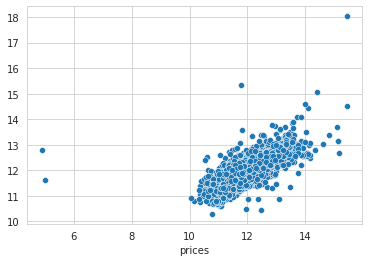

In [444]:
sns.scatterplot(y_test, predictions)

In [445]:
lm.score(X_train, y_train)

0.6285348534002424

In [446]:
lm.score(X_test, y_test)

0.5971280006724321

In [431]:
predictions

array([249505.6892195 ,  88259.91503765, 417139.7228086 , ...,
       348868.41247611, 237080.1980393 , 217899.76424897])

In [432]:
np.array(y_test)

array([108000, 109000, 500000, ..., 215000, 124000, 220000])

In [447]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [450]:
mean_absolute_error(y_test, predictions)

0.2627199742335076

In [451]:
mean_absolute_error(np.exp(y_test), np.exp(predictions))

64703.469854256706

In [437]:
temp = pd.DataFrame()
temp['features'] = X_train.columns.values
temp['coef'] = lm.coef_

In [419]:
np.exp(predictions)

array([226936.83247888,  91222.59912137, 399830.97859013, ...,
       340244.51316192, 183262.26159937, 181609.9697326 ])

In [421]:
np.array(np.exp(y_test))

array([108000., 109000., 500000., ..., 215000., 124000., 220000.])

### H2O

In [ ]:
!apt-get install default-jre
!java -version
!pip install h2o

In [ ]:
import h2o
h2o.init()

In [387]:
df = pd.read_excel("for_h2o.xlsx")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [376]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [379]:
df.to_csv("for_h2o.csv")

In [363]:
from h2o.automl import H2OAutoML

In [364]:
df.to_excel('for_h2o.xlsx')

In [452]:
df = h2o.import_file('/content/for_h2o.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [453]:
df_train, df_test, df_validation = df.split_frame([.7, .15])

In [454]:
y = 'prices'
x = df.columns
x.remove('C1')
x.remove('prices')

In [385]:
aml = H2OAutoML(
    nfolds=0,
    balance_classes=True,
    max_runtime_secs=480,
    seed=42,
    stopping_metric="RMSE"
)

In [386]:
aml.train(x,y,training_frame=df_train, validation_frame=df_validation)

AutoML progress: |██████████████
18:06:54.213: DeepLearning_1_AutoML_1_20220108_180551 [DeepLearning def_1] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DeepLearning model: DeepLearning_1_AutoML_1_20220108_180551.  Details: ERRR on field: _balance_classes: balance_classes requires classification.


█████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_1_20220108_180551_model_11


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,367174.0,17.0,17.0,17.0,66.0,640.0,286.67




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 3195416889.534165
RMSE: 56528.018623813135
MAE: 16454.14152325383
RMSLE: NaN
Mean Residual Deviance: 3195416889.534165

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 6884821600.074996
RMSE: 82974.82509818864
MAE: 31154.56166044534
RMSLE: 0.20106849655048906
Mean Residual Deviance: 6884821600.074996

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2022-01-08 18:10:37,29.909 sec,0.0,193464.487555,95369.499263,3.742851e+10,172637.216478,96757.889056,2.980361e+10
1,,2022-01-08 18:10:37,30.318 sec,5.0,142377.417772,60810.682101,2.027133e+10,124876.893532,62738.717182,1.559424e+10
2,,2022-01-08 18:10:38,30.687 sec,10.0,116019.280116,42382.562173,1.346047e+10,104511.015459,45888.351389,1.092255e+10
3,,2022-01-08 18:10:38,31.127 sec,15.0,101051.992329,32712.741147,1.021151e+10,94926.300067,38121.899055,9.011002e+09
4,,2022-01-08 18:10:38,31.507 sec,20.0,92838.552847,26975.489492,8.618997e+09,90820.842910,34018.434788,8.248426e+09
5,,2022-01-08 18:10:39,31.839 sec,25.0,87131.253126,24076.752026,7.591855e+09,89681.682809,32330.218604,8.042804e+09
6,,2022-01-08 18:10:39,32.175 sec,30.0,83777.472729,22454.779579,7.018665e+09,88612.624968,31493.479619,7.852197e+09
7,,2022-01-08 18:10:39,32.493 sec,35.0,80393.329792,21137.245124,6.463087e+09,87918.343281,30933.279154,7.729635e+09
8,,2022-01-08 18:10:40,32.793 sec,40.0,77564.290866,20423.268646,6.016219e+09,86734.646275,30877.888496,7.522899e+09
9,,2022-01-08 18:10:40,33.085 sec,45.0,74872.913964,19957.959852,5.605953e+09,86738.510308,30887.646634,7.523569e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,areas_m2,9.937332e+14,1.000000,0.539165
1,rooms,1.999907e+14,0.201252,0.108508
2,longitudes,1.374718e+14,0.138339,0.074587
3,latitudes,1.342991e+14,0.135146,0.072866
4,buildings_floor,1.076043e+14,0.108283,0.058382
5,watches,9.377140e+13,0.094363,0.050877
6,percent_of_building_height,7.330062e+13,0.073763,0.039770
7,apartment_floor,4.137454e+13,0.041635,0.022448
8,Yeni tikili,3.629349e+13,0.036522,0.019692
9,mülkiyyətçi,7.307613e+12,0.007354,0.003965



See the whole table with table.as_data_frame()
